In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import decomposition
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn import preprocessing
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, homogeneity_score, silhouette_score, classification_report
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve
import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset_select =     0    # 0 for wine , 1 for cancer

In [3]:
if dataset_select == 0:
    wine = pd.read_csv('data/wine.csv',sep=';')
    print('Wine Quality Dataset')
    print(wine.shape)
    bins = (2, 6.5, 8)
    group_names = ['bad','good']
    wine['quality'] = pd.cut(wine['quality'], bins=bins,labels=group_names)
    wine = wine.dropna()
    wine_label_quality = LabelEncoder()
    wine['quality'] = wine_label_quality.fit_transform(wine['quality'])
    df = wine
    X = wine.drop('quality',axis=1)
    y = wine['quality']
    dataset='wine'
elif dataset_select == 1:
    print('Cancer Dataset')
    cancer = pd.read_csv('data/cancer.csv')
    print(cancer.shape)
    cancer = cancer.dropna()
    cancer['class']=cancer['class'].map({4:1, 2:0})
    df = cancer
    X = cancer.drop(['id','class'],axis=1)
    y = cancer['class'] 
    dataset='cancer'
else:
    raise Exception('dataset_select field must be 0 for wine , 1 for cancer')

X = MinMaxScaler().fit_transform(X)

Wine Quality Dataset
(4898, 12)


In [4]:
rp_7 = GaussianRandomProjection(n_components=8, random_state=44)
rp_7.fit(X)
X_rp_7 = rp_7.transform(X)

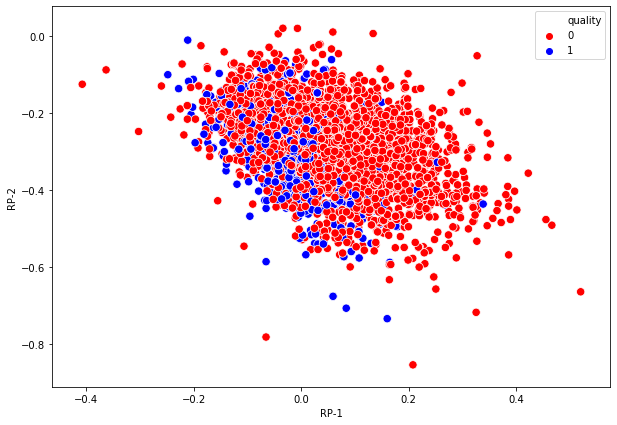

In [5]:
plt.figure(figsize=(10,7))
sns.scatterplot(x=X_rp_7[:, 0],
                y=X_rp_7[:,1],
                s = 70,
                hue=y, palette=['red','blue'])
plt.xlabel('RP-1')
plt.ylabel('RP-2')
plt.savefig('img/2d RP cluster '+dataset+'.png')
plt.show()

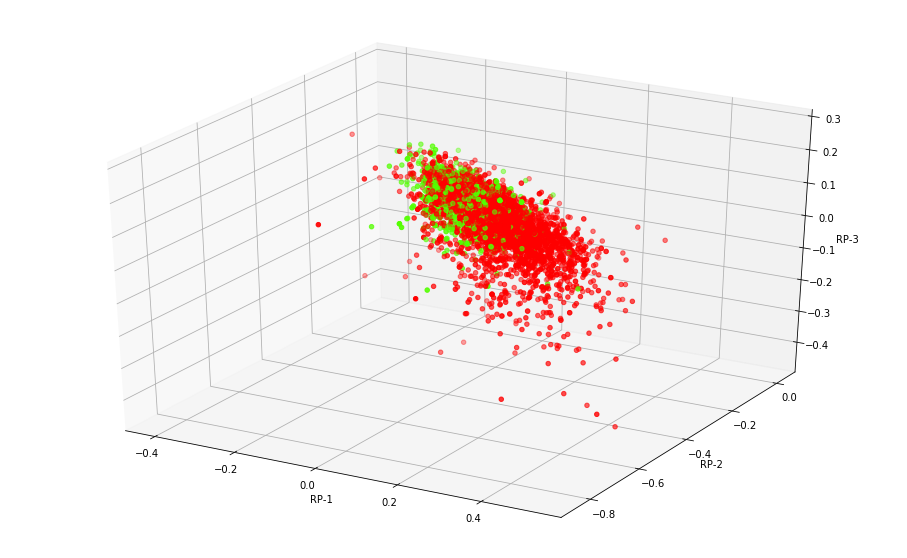

In [6]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=X_rp_7[:, 0], 
    ys=X_rp_7[:, 1], 
    zs=X_rp_7[:, 2], 
    c=y, 
    cmap='prism'
)
ax.set_xlabel('RP-1')
ax.set_ylabel('RP-2')
ax.set_zlabel('RP-3')
plt.savefig('img/2d RP cluster '+dataset+'.png')
plt.show()

In [7]:
N = np.arange(2, 41, 1)
S,H = [],[]
for n in N:
    km = KMeans(n_clusters=n,
                n_init=50,
                max_iter=1000,
                random_state=44).fit(X_rp_7)
    S.append(silhouette_score(X, km.labels_, metric='euclidean'))
    H.append(homogeneity_score(y, km.labels_))

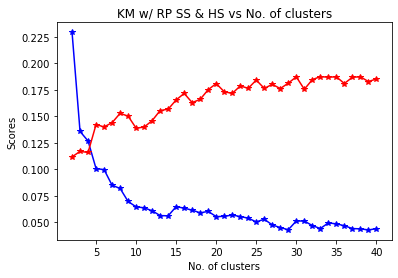

In [8]:
plt.figure()
plt.plot(N, S, '*-',color='b',label='Silhouette')
plt.plot(N, H, '*-',color='r',label='Homogeneity')
plt.title('')
plt.xlabel('No. of clusters')
plt.ylabel('Scores')
plt.title('KM w/ RP SS & HS vs No. of clusters')
plt.savefig('img/KM RP scores '+dataset+'.png')
plt.show()

In [9]:
S, H, L = [],[],[]
for n in N:
    gmm = GaussianMixture(n_components=n,
                          max_iter=100,
                          random_state=44, 
                          n_init=5).fit(X_rp_7)
    l = gmm.predict(X_rp_7)
    S.append(silhouette_score(X, l, metric='euclidean'))
    H.append(homogeneity_score(y, l))
    L.append(gmm.score(X_rp_7))

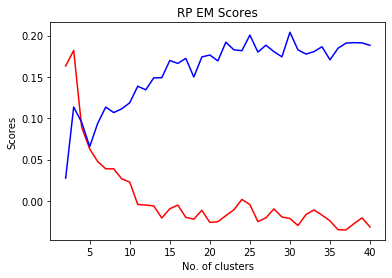

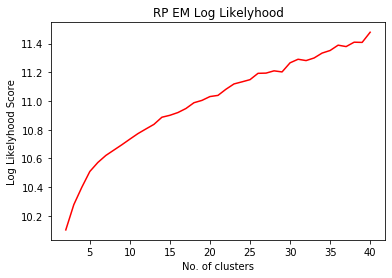

In [10]:
plt.figure()
plt.plot(N, S, color='r')
plt.plot(N, H, color='b')
plt.title('RP EM Scores')
plt.xlabel('No. of clusters')
plt.ylabel('Scores')
plt.savefig('img/EM RP Scores '+dataset+'.png')
plt.show()

plt.figure()
plt.plot(N, L, color='r')
plt.title('RP EM Log Likelyhood')
plt.xlabel('No. of clusters')
plt.ylabel('Log Likelyhood Score')
plt.savefig('img/EM RP Log '+dataset+'.png')
plt.show()

Tuned Accuracy: 80.25%
[learning_curve] Training set sizes: [ 274  548  822 1096 1370 1644 1918 2192 2466 2740]


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  17 out of  50 | elapsed:   10.4s remaining:   20.2s
[Parallel(n_jobs=2)]: Done  34 out of  50 | elapsed:   20.6s remaining:    9.7s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   31.5s finished


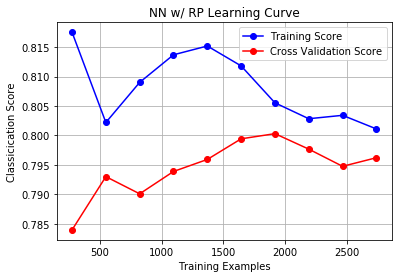

No handles with labels found to put in legend.


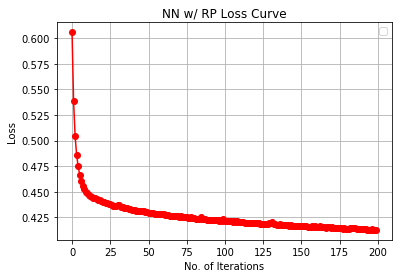

In [11]:
if dataset_select == 0:
    X_train, X_test, y_train, y_test = train_test_split(X_rp_7, 
                                                        y, 
                                                        test_size=0.3, 
                                                        random_state=42,
                                                        stratify=y)
    nn_clf = MLPClassifier()
    nn_clf.fit(X_train, y_train)
    nn_y_pred = nn_clf.predict(X_test)
    nn_acc = accuracy_score(y_test, nn_y_pred)*100
    print("Tuned Accuracy: %.2f%%"%nn_acc)
    train_sizes, nn_train_scores, test_scores = learning_curve(nn_clf,
                                                               X_train,
                                                               y_train,
                                                               train_sizes=np.linspace(0.1,1.0,10),
                                                               verbose=3,
                                                               n_jobs=2)
    plt.figure()
    plt.plot(train_sizes, np.mean(nn_train_scores, axis=1),'o-',
            label='Training Score',color='blue')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-',
            label='Cross Validation Score',color='red')
    plt.title('NN w/ RP Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Classicication Score')
    plt.legend()
    plt.grid()
    plt.savefig('img/RP_NN_learning '+dataset+'.png')
    plt.show()
    nn_loss= nn_clf.loss_curve_
    plt.figure()
    plt.title('NN w/ RP Loss Curve')
    plt.xlabel('No. of Iterations')
    plt.ylabel('Loss')
    plt.plot(nn_loss, 'o-', color='red')
    plt.grid()
    plt.savefig('img/RP_NN_loss '+dataset+'.png')
    plt.show()